### import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as smf
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

plt.rc("font", size=14)

import warnings
warnings.filterwarnings('ignore')


### load and preprocess the dataset

In [2]:
df = pd.read_excel('inflation_data_18_23_new.xlsx')
df = df.dropna()
df.head()

,month,exchange_rate,cpi,ihsg,broad_money_m2,bi_rate,inflation
0,2014-01-01,15511.000,110.99,4418.76,3652349.28,7.5,8.22
1,2014-02-01,15598.636,111.28,4620.22,3643059.46,7.5,7.75
2,2014-03-01,15759.864,111.37,4768.28,3660605.98,7.5,7.32
3,2014-04-01,15366.700,111.35,4840.15,3730376.45,7.5,7.25
4,2014-05-01,15251.727,111.53,4893.91,3789278.64,7.5,7.32


In [3]:
# dimension dataset
print(df.shape)
print(list(df.columns))

(120, 7)
['month', 'exchange_rate', 'cpi', 'ihsg', 'broad_money_m2', 'bi_rate', 'inflation']


### labeling inflation_rate as binary: ```0 for low inflation``` and ```1 for high inflation```
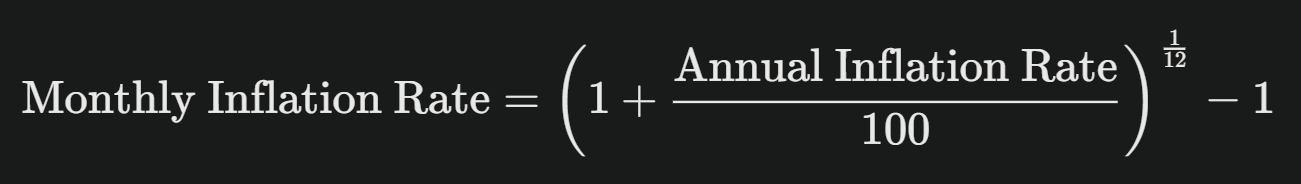

In [4]:
# defining the given annual inflation rate
annual_inflation_rate = 30 / 100  # 30% annual inflation in decimal

# converting annual inflation to monthly using the formula
monthly_inflation_rate = (1 + annual_inflation_rate) ** (1/12) - 1

# converting monthly inflation rate to percentage and rounding to two decimal places
monthly_inflation_rate_percent = round(monthly_inflation_rate * 100, 2)
monthly_inflation_rate_percent

2.21

In [5]:
# create biner label 1 (high inflation) and 0 (low inflation)
df['inflation_class'] = (df['inflation'] > 2.21).astype(int)
df.head()

,month,exchange_rate,cpi,ihsg,broad_money_m2,bi_rate,inflation,inflation_class
0,2014-01-01,15511.000,110.99,4418.76,3652349.28,7.5,8.22,1
1,2014-02-01,15598.636,111.28,4620.22,3643059.46,7.5,7.75,1
2,2014-03-01,15759.864,111.37,4768.28,3660605.98,7.5,7.32,1
3,2014-04-01,15366.700,111.35,4840.15,3730376.45,7.5,7.25,1
4,2014-05-01,15251.727,111.53,4893.91,3789278.64,7.5,7.32,1


In [6]:
# remove unnecessary columns
df.drop(['month', 'inflation'], axis=1, inplace= True)
df.head()

,exchange_rate,cpi,ihsg,broad_money_m2,bi_rate,inflation_class
0,15511.000,110.99,4418.76,3652349.28,7.5,1
1,15598.636,111.28,4620.22,3643059.46,7.5,1
2,15759.864,111.37,4768.28,3660605.98,7.5,1
3,15366.700,111.35,4840.15,3730376.45,7.5,1
4,15251.727,111.53,4893.91,3789278.64,7.5,1


In [7]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   exchange_rate    120 non-null    float64
 1   cpi              120 non-null    float64
 2   ihsg             120 non-null    float64
 3   broad_money_m2   120 non-null    float64
 4   bi_rate          120 non-null    float64
 5   inflation_class  120 non-null    int32  
dtypes: float64(5), int32(1)
memory usage: 5.3 KB


In [8]:
# describe data
df.describe()

,exchange_rate,cpi,ihsg,broad_money_m2,bi_rate,inflation_class
count,120.000000,120.000000,120.000000,1.200000e+02,120.000000,120.000000
mean,13931.482417,119.647083,5841.951500,5.958003e+06,5.350000,0.816667
std,997.336552,10.901747,804.005565,1.476086e+06,1.385379,0.388562
min,11427.050000,104.330000,4223.910000,3.643059e+06,3.500000,0.000000
25%,13341.574000,111.065000,5146.077500,4.735683e+06,4.250000,1.000000
50%,14065.307000,118.380000,5949.800000,5.670876e+06,5.250000,1.000000
75%,14565.495000,129.767500,6484.812500,7.137686e+06,6.000000,1.000000
max,15867.429000,139.070000,7272.800000,8.826531e+06,7.750000,1.000000


In [9]:
# count the occurrences of each category in the 'inflation_class' column
df['inflation_class'].value_counts()


inflation_class
1    98
0    22
Name: count, dtype: int64

### plot distribution of the data label (inflation_class)

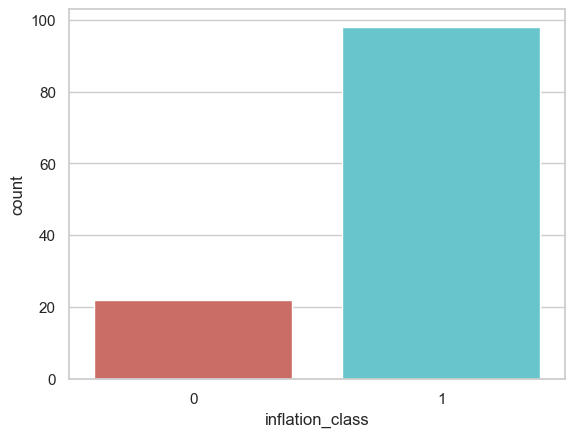

<Figure size 640x480 with 0 Axes>

In [10]:
# plot the distribution of the 'inflation_class' column using a count plot
sns.countplot(x='inflation_class', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

In [11]:
# calculate the percentage of low and high inflation instances
count_low_inflation = len(df[df['inflation_class'] == 0])  # C]count instances of low inflation
count_high_inflation = len(df[df['inflation_class'] == 1])  # count instances of high inflation
pct_of_low_inflation = count_low_inflation / (count_low_inflation + count_high_inflation)
print('percentage of low inflation is', pct_of_low_inflation * 100)
pct_of_high_inflation = count_high_inflation / (count_low_inflation + count_high_inflation)
print('percentage of high inflation is', pct_of_high_inflation * 100)


percentage of low inflation is 18.333333333333332
percentage of high inflation is 81.66666666666667


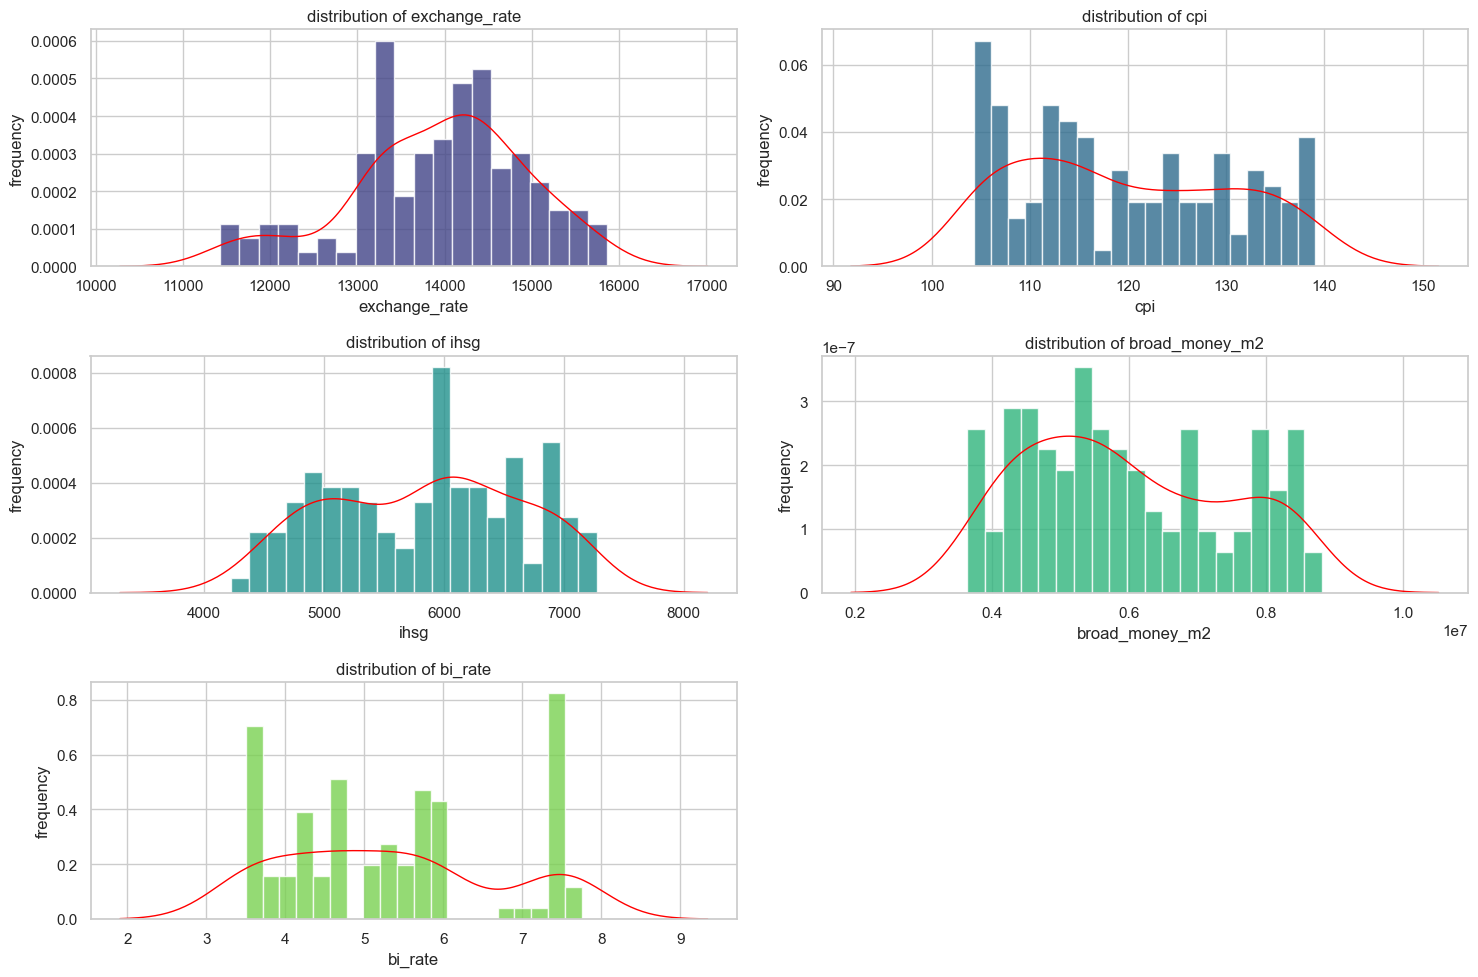

In [12]:
# plot histograms for all independent variables
independent_columns = df.drop(columns=['inflation_class']).select_dtypes(include=['float64']).columns

plt.figure(figsize=(15, 10))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(independent_columns)))
for i, column in enumerate(independent_columns, 1):
    plt.subplot(len(independent_columns) // 2 + 1, 2, i)
    plt.hist(df[column], bins=20, alpha=0.8, color=colors[i-1], density=True)
    
    sns.kdeplot(df[column], color='red', linewidth=1)
    plt.title(f'distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('frequency')

plt.tight_layout()
plt.show()


In [13]:
# group the data by 'inflation_class' and calculate the mean for each group
df.groupby('inflation_class').mean()

,exchange_rate,cpi,ihsg,broad_money_m2,bi_rate
inflation_class,,,,,
0,13358.129636,106.158636,5919.266364,7.042610e+06,3.704545
1,14060.194265,122.675102,5824.595102,5.714520e+06,5.719388


<Axes: >

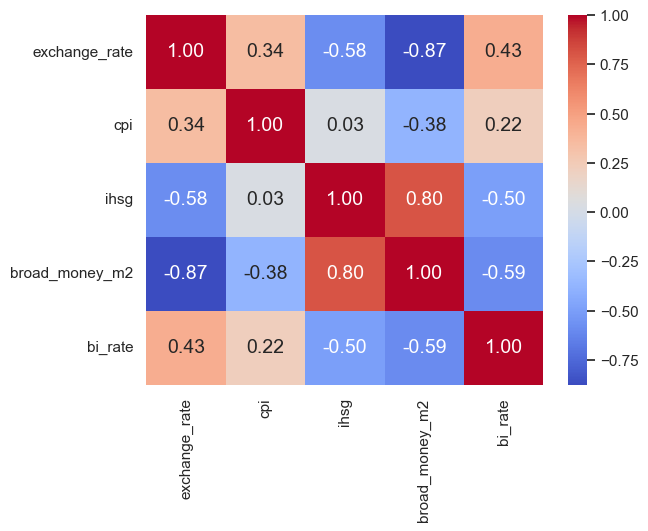

In [14]:
# correlation matrix (heatmap)
correlation_matrix = df.drop('inflation_class', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")

In [15]:
# split data into dependent and independent variables
X = df.drop('inflation_class', axis=1)  # independent variables (features)
y = df['inflation_class']  # dependent variable (target)

In [16]:
# standardize the data
def min_max_normalization(column):
    return (column - column.min()) / (column.max() - column.min())

X_scaled = X.apply(min_max_normalization)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### multicollinearity test using VIF

In [17]:
# function to calculate vif
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# calculate vif
vif_results = calculate_vif(X_scaled)

print(vif_results)

          feature        VIF
0   exchange_rate   6.003277
1             cpi   4.927328
2            ihsg  23.894890
3  broad_money_m2  15.618477
4         bi_rate   3.577085


In [18]:
pca = PCA(random_state=42)
X_reduced = pca.fit_transform(X_scaled)
X_reduced = pd.DataFrame(X_reduced, columns=X.columns)

print("PCA is applied because there are variables with VIF greater than 10.")

PCA is applied because there are variables with VIF greater than 10.


In [19]:
vif_after_pca = calculate_vif(X_reduced)

print(vif_after_pca)

          feature  VIF
0   exchange_rate  1.0
1             cpi  1.0
2            ihsg  1.0
3  broad_money_m2  1.0
4         bi_rate  1.0


### oversampling with SMOTE

In [20]:
# add the target column to the standardized DataFrame
df_reduced = pd.concat([X_reduced, y.reset_index(drop=True)], axis=1)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_reduced, 
    df_reduced['inflation_class'], 
    test_size=0.3, 
    random_state=42, 
    stratify=df_reduced['inflation_class']
)

# create an SMOTE object for oversampling
os = SMOTE(random_state=2)

# oversample the training data
os_data_X, os_data_y = os.fit_resample(X_train.drop('inflation_class', axis=1), y_train)  # Use fit_resample

# check the number of data points
print("Length of oversampled data is", len(os_data_X))
print("Number of low inflation instances in oversampled data:", len(os_data_y[os_data_y == 0]))  # Adjusted for Series
print("Number of high inflation instances:", len(os_data_y[os_data_y == 1]))  # Adjusted for Series
print("Proportion of low inflation data in oversampled data is", len(os_data_y[os_data_y == 0]) / len(os_data_X))
print("Proportion of high inflation data in oversampled data is", len(os_data_y[os_data_y == 1]) / len(os_data_X))

Length of oversampled data is 138
Number of low inflation instances in oversampled data: 69
Number of high inflation instances: 69
Proportion of low inflation data in oversampled data is 0.5
Proportion of high inflation data in oversampled data is 0.5


### select feature

In [21]:
# sssuming df is already defined and the 'inflation_class' column exists
df_vars = df_reduced.columns.values.tolist()  # Get all column names from the reduced DataFrame
y = ['inflation_class']  # Define the target variable
X = [i for i in df_vars if i not in y]  # Create a list of independent variables

# create a logistic regression model
logreg = LogisticRegression()

# apply RFE 
# make sure to pass only the estimator and the number of features to select
rfe = RFE(estimator=logreg, n_features_to_select=5)  # specify the estimator and the number of features to select
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())  # fit the RFE model; ensure os_data_y is 1D

print("Selected Features:", rfe.support_)  # boolean mask of selected features
print("Feature Ranking:", rfe.ranking_)  # ranking of features

Selected Features: [ True  True  True  True  True]
Feature Ranking: [1 1 1 1 1]


In [22]:
# define the columns to include in X, excluding 'label_inflasi'
cols = [col for col in df_reduced.columns if col != 'inflation_class']

# define X and y
X = os_data_X[cols]  # Features

# assign y based on the type of os_data_y
if isinstance(os_data_y, pd.Series):
    y = os_data_y  # if it's a Series, assign directly
else:
    # check if 'label_inflasi' exists in os_data_y columns
    if 'inflation_class' in os_data_y.columns:
        y = os_data_y['inflation_class']  # use this if os_data_y is a dataframe
    else:
        raise KeyError("The target variable 'inflation_class' does not exist in os_data_y")

### modeling probit regression

In [23]:
# probit model
probit_model=smf.Probit(y,X)
result=probit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.303720
         Iterations 7
                         Results: Probit
Model:              Probit           Method:           MLE       
Dependent Variable: inflation_class  Pseudo R-squared: 0.562     
Date:               2024-09-30 22:56 AIC:              93.8267   
No. Observations:   138              BIC:              108.4629  
Df Model:           4                Log-Likelihood:   -41.913   
Df Residuals:       133              LL-Null:          -95.654   
Converged:          1.0000           LLR p-value:      2.5055e-22
No. Iterations:     7.0000           Scale:            1.0000    
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
exchange_rate     -1.6625   0.3290 -5.0537 0.0000 -2.3073 -1.0177
cpi                2.2943   0.5587  4.1062 0.0000  1.1992  3.3894

In [24]:
probit_model=smf.Probit(y,X)
result=probit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.303720
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:        inflation_class   No. Observations:                  138
Model:                         Probit   Df Residuals:                      133
Method:                           MLE   Df Model:                            4
Date:                Mon, 30 Sep 2024   Pseudo R-squ.:                  0.5618
Time:                        22:56:50   Log-Likelihood:                -41.913
converged:                       True   LL-Null:                       -95.654
Covariance Type:            nonrobust   LLR p-value:                 2.506e-22
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
exchange_rate     -1.6625      0.329     -5.054      0.000      -2.307      -1.018
cpi              

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
probit=smf.Probit(y_train,X_train)
probit.fit()
print(probit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.289215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.289215
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:        inflation_class   No. Observations:                   96
Model:                         Probit   Df Residuals:                       91
Method:                           MLE   Df Model:                            4
Date:                Mon, 30 Sep 2024   Pseudo R-squ.:                  0.5828
Time:                        22:56:50   Log-Likelihood:                -27.765
converged:                       True   LL-Null:                       -66.542
Covariance Type:            nonrobust   LLR p-value:                 5.738e-16
                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

In [26]:
# retrieve coefficients from the fitted Probit model
params = pd.DataFrame(probit.fit().params, columns=['coef'])
params


Optimization terminated successfully.
         Current function value: 0.289215
         Iterations 6


,coef
exchange_rate,-1.807414
cpi,1.653282
ihsg,3.069861
broad_money_m2,-1.362224
bi_rate,-2.406863


In [27]:
# model prediction to find y_pred
result1 = X_test
result1['y_pred'] = result1['exchange_rate'] * params['coef'][0] + result1['cpi'] * params['coef'][1] + result1['ihsg'] * params['coef'][2] +  result1['broad_money_m2'] * params['coef'][3] +  result1['bi_rate'] * params['coef'][4]
result1.head()

,exchange_rate,cpi,ihsg,broad_money_m2,bi_rate,y_pred
53,-0.241841,0.489246,0.108756,0.046192,0.087220,1.306984
62,0.570549,0.019322,0.493388,-0.078180,-0.029551,0.692982
121,0.324396,-0.424309,-0.240381,-0.162464,0.055408,-1.937803
129,0.633944,-0.172699,-0.164199,0.100550,0.013090,-2.103864
135,0.453651,-0.298579,-0.177389,0.015983,-0.043482,-1.775248


In [28]:
import scipy.stats as si
def normsdist(z):
    z = si.norm.cdf(z,0.0,1.0)
    return (z)
normsdist(1.645)

0.9500150944608786

In [29]:
# find y_pred probit
result1['y_pred_Probit'] = normsdist(result1['y_pred'])
result1.head()

,exchange_rate,cpi,ihsg,broad_money_m2,bi_rate,y_pred,y_pred_Probit
53,-0.241841,0.489246,0.108756,0.046192,0.087220,1.306984,0.904391
62,0.570549,0.019322,0.493388,-0.078180,-0.029551,0.692982,0.755839
121,0.324396,-0.424309,-0.240381,-0.162464,0.055408,-1.937803,0.026324
129,0.633944,-0.172699,-0.164199,0.100550,0.013090,-2.103864,0.017695
135,0.453651,-0.298579,-0.177389,0.015983,-0.043482,-1.775248,0.037928


In [30]:
# predict result
d = {'y_pred_proba': result1['y_pred_Probit']}
df23 = pd.DataFrame(data=d)
df23 = df23.reset_index()
df23.drop(['index'], axis=1, inplace=True)
df23['y_pred'] = 0.000
for i in range(0,len(df23['y_pred_proba'])):
    if df23['y_pred_proba'][i] > 0.500:
        df23['y_pred'][i] = 1.000
    else: 
        df23['y_pred'][i] = 0.000
y_pred = np.array(df23['y_pred'])
y_pred = y_pred.astype('int64')
y_pred

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1],
      dtype=int64)

In [31]:
# accuracy model
print('accuracy of Probit Model on test set: {:.2f}'.format(accuracy_score(y_test, y_pred)))

accuracy of Probit Model on test set: 0.88


In [32]:
# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print('confusion matrix:\n', confusion_matrix)

confusion matrix:
 [[21  0]
 [ 5 16]]


In [33]:
# classification report
print('classification report:')
print(classification_report(y_test, y_pred))

classification report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        21
           1       1.00      0.76      0.86        21

    accuracy                           0.88        42
   macro avg       0.90      0.88      0.88        42
weighted avg       0.90      0.88      0.88        42



In [34]:
y_pred_proba = np.array(df23['y_pred_proba'])
y_pred_proba

array([0.90439097, 0.75583946, 0.0263236 , 0.01769515, 0.03792846,
       0.02301017, 0.02246251, 0.02754914, 0.92816082, 0.02194057,
       0.86920559, 0.02705849, 0.02468807, 0.86256114, 0.76255786,
       0.64286454, 0.55418686, 0.05061726, 0.03586259, 0.16348939,
       0.91106251, 0.02452253, 0.02583996, 0.01203217, 0.47143543,
       0.86686967, 0.0260266 , 0.02401423, 0.02709315, 0.01755606,
       0.04343559, 0.00898781, 0.87822812, 0.28022701, 0.54715678,
       0.01977891, 0.0291018 , 0.024575  , 0.68073019, 0.51702834,
       0.62198481, 0.61665197])

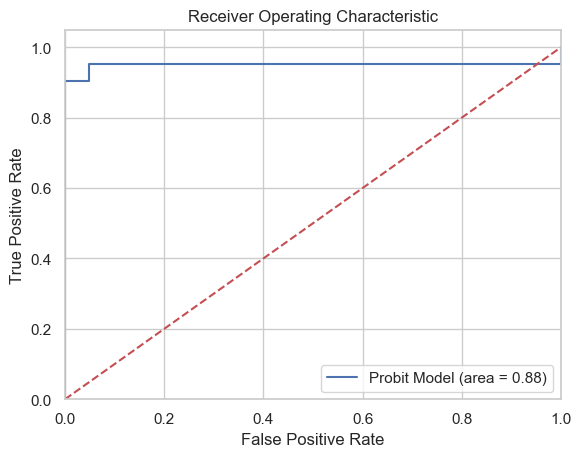

In [35]:
# roc auc
probit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Probit Model (area = %0.2f)' % probit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Probit_ROC')
plt.show()